## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 12:01:32.230599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 12:01:32.230617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
data=pd.read_csv('preprocessed_migraine_data.csv')

In [7]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
np.random.seed(42)
data=data.sample(frac=1)

In [9]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [10]:
data['Type'].value_counts()

 0    241
 1     60
 2     24
 3     20
 4     18
-1     17
 5     14
Name: Type, dtype: int64

In [11]:
data = data.drop(data[data.Type == -1].index)

In [12]:
data['Type'].value_counts()

0    241
1     60
2     24
3     20
4     18
5     14
Name: Type, dtype: int64

In [13]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/Migraine.csv")
data.to_csv(output_file_path, index=False)

In [14]:
data.drop(['Type'],axis=1, inplace=True)

In [15]:
np.random.seed(42)
data=data.sample(frac=1)

In [16]:
values=['Age','Duration','Frequency','Intensity','Visual','Nausea', 'Vomit','Location','Character','Dysphasia', 'Vertigo', 'Tinnitus','Sensory','Phonophobia','Photophobia', 'Hypoacusis', 'Diplopia', 'Defect','Conscience', 'Paresthesia', 'DPF']

In [17]:
data=data[values]

### UMAP on entire data

In [18]:
from fdc.fdc import feature_clustering

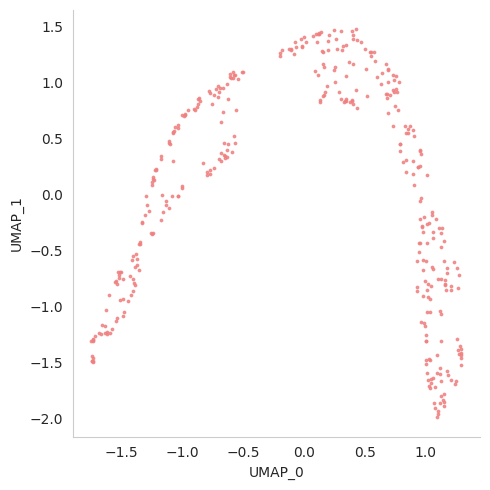

In [19]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [20]:
cont_list=['Age']

ord_list=['Duration','Frequency','Intensity','Visual','Nausea', 'Vomit']

nom_list=['Location','Character','Dysphasia', 'Vertigo', 'Tinnitus','Sensory','Phonophobia','Photophobia', 'Hypoacusis', 'Diplopia', 'Defect','Conscience', 'Paresthesia', 'DPF']

target = ['Type']


In [21]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/Migraine.json")

In [22]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 2.14630 / 2.146s


FDC.normalize (clustering ORD): 2.04515 / 4.191s
FDC.normalize (clustering NOM): 0.00005 / 4.192s
FDC.normalize (concat): 0.00002 / 4.192s


FDC.normalize (umap 5 -> 2): 1.18695 / 5.378s
FDC.normalize (array -> DataFrame): 0.00026 / 5.379s


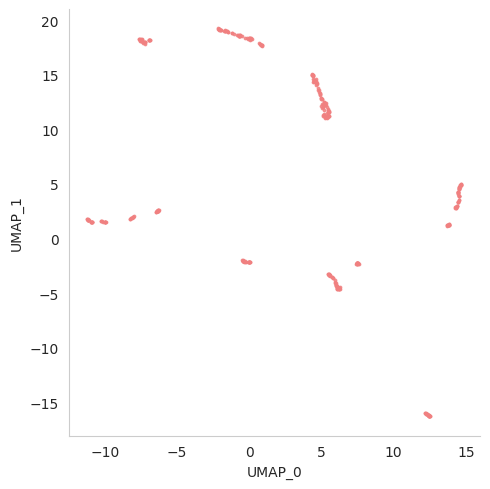

FDC.normalize (plotting): 0.40254 / 5.781s
FDC.normalize (array -> DataFrame): 0.00017 / 5.781s
FDC.normalize (total): 0.00001 / 5.781s


In [23]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

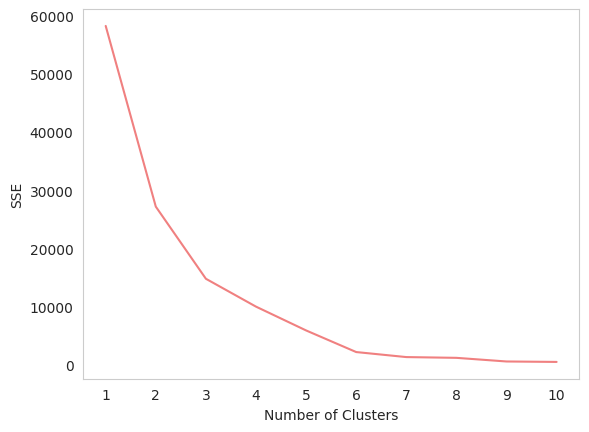

In [24]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [25]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [26]:
find_optimal_cluster(FDC_emb_low)

[0.50990045,
 0.59335613,
 0.64083356,
 0.6717999,
 0.7620563,
 0.80570585,
 0.8318305]

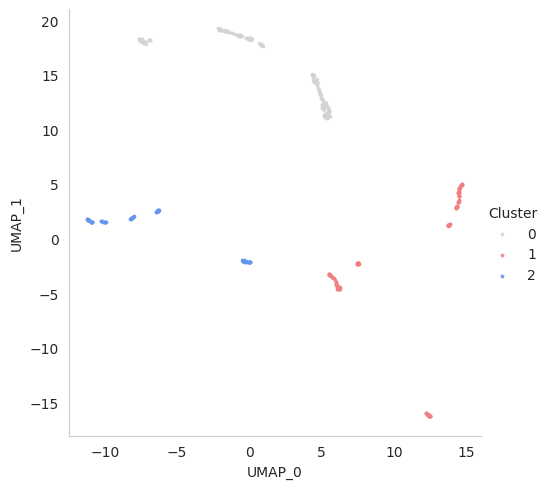

In [27]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

In [28]:
cluster_counts

array([171, 131,  75])

In [29]:
data['Target']=cluster_list

In [30]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSMigraine.csv")
data.to_csv(output_file_path, index=False)

In [31]:
data

,Age,Duration,Frequency,Intensity,Visual,Nausea,Vomit,Location,Character,Dysphasia,...,Sensory,Phonophobia,Photophobia,Hypoacusis,Diplopia,Defect,Conscience,Paresthesia,DPF,Target
300,28,3,5,3,0,1,1,1,1,0,...,0,1,1,0,0,0,0,0,0,1
272,26,2,3,3,0,1,0,1,1,0,...,0,1,1,0,0,0,0,0,1,0
276,21,1,2,2,1,1,0,1,1,0,...,2,1,1,0,0,0,0,0,1,0
151,21,1,2,3,1,1,0,1,1,0,...,0,1,1,0,0,0,0,0,0,0
59,28,2,3,3,2,1,0,1,1,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,20,1,2,2,2,1,0,1,1,0,...,0,1,1,0,0,0,0,0,0,0
112,16,1,1,3,0,1,0,1,1,0,...,0,1,1,0,0,0,0,0,0,0
284,28,2,4,3,2,1,1,1,1,0,...,0,1,1,0,0,0,0,0,1,1
364,19,1,2,1,3,1,1,1,1,0,...,2,1,1,0,0,0,0,0,0,0
